<a href="https://www.kaggle.com/code/lucascarpantonio/titanic-machine-learning-from-disaster?scriptVersionId=288424088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/lucascarpantonio/titanic-machine-learning-from-disaster?scriptVersionId=285818002" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        directory = os.path
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Introduction

On the night of April 14th, 1912, an engineering marvel called RMS Titanic struck an iceberg during its maiden voyage and tragically sank in the North Atlantic. Of the more than 2,200 passengers and crew on board, only around 32% survived. The disaster revealed how social class, cabin location, age, gender and family structure profoundly influenced the likelihood of survival.

The purpose of this analysis is to explore these factors using the Titanic dataset provided by Kaggle:  
1. to explore data features,  
2. to build a predictive model using rigorous data preparation and feature engineering, and  
3. to generate survival predictions for the passengers in the test set.

This notebook follows a structured workflow — from exploratory data analysis to model training and final prediction — aiming to reproduce, as faithfully as possible, the real-world patterns that shaped survival on the Titanic.

## 1.1 Data Import

In [2]:
# loading training data (use local Kaggle input path)
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.info()
train_data.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [3]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.info()
test_data.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


In [4]:
# Some calculation to expand data such as Family info

for df in (train_data, test_data):
    df['Fare'] = pd.to_numeric(df['Fare'], errors='coerce')
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Fare'] = df['Fare'].clip(lower=0)
    df['LogFare'] = np.log1p(df['Fare'])
    df['FamilySize'] = df['SibSp']+ df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df["Title"] = df["Name"].str.extract(r',\s*([^\.]+)\.', expand=False)
    df["Title"] = df["Title"].replace({
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Lady": "Royalty", "Countess": "Royalty",
    "Sir": "Royalty", "Jonkheer": "Royalty",
    "Don": "Royalty", "Dona": "Royalty",
    "Dr": "Officer", "Rev": "Officer",
    "Col": "Officer", "Major": "Officer", "Capt": "Officer"})
    df["TicketGroupSize"] = df.groupby("Ticket")["Ticket"].transform("count") # one ticket multiple persons
    df["FarePerPerson"] = df["Fare"] / df["TicketGroupSize"]
    df["Age"] = df.groupby("Sex")["Age"].transform( #The imputer would not segment per group. Sex seems to be 
        lambda x: x.fillna(x.mean()))
    

# 2. Some historical curiosity

## 2.1 Does all passangers have an embarkment port associated?

It looks like that a couple of passagenrs do not have a the Embarkment point recorde. Because could represent a relavant piece of information upon defining the model, the fare ticket may help to define the Embarkment place.

In [5]:
train_data[train_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,FamilySize,IsAlone,Title,TicketGroupSize,FarePerPerson
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,4.394449,1,1,Miss,2,40.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,4.394449,1,1,Mrs,2,40.0


In [6]:
# Check statistical data for Fare from different Embarkment point
train_data.groupby('Embarked')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,168.0,59.954144,83.912994,4.0125,13.69795,29.70,78.500025,512.3292
Q,77.0,13.276030,14.188047,6.7500,7.75000,7.75,15.500000,90.0000
S,644.0,27.079812,35.887993,0.0000,8.05000,13.00,27.900000,263.0000


In [7]:
# Set Cherbourg as main dock according to fare cost.
train_data['Embarked'] = train_data['Embarked'].fillna('C')

# Confirming that all passangers have an Embarkment dock
train_data['Embarked'].isna().sum()

0

#### Observations
- The dataset shows that only **two passengers** have a missing value in the `Embarked` column.  
- A comparison of fare distributions across embarkment ports (`train_data.groupby('Embarked')['Fare'].describe()`) indicates that ticket prices differ significantly between Southampton (S), Cherbourg (C), and Queenstown (Q).  
- Based on their fare (£80), these two passengers are **closer to the typical price range of tickets purchased at Cherbourg** rather than Southampton.  
- However, since the historical record is incomplete and the impact on the model is negligible (2 out of 891 entries), a conservative and standard approach is to impute the missing values with `'S'`, as commonly done in Kaggle Titanic preprocessing.


## 2.2 What's the suvival rate versus family size?

In [8]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)

# Calculate survival rate for each FamilySize and Sex
fs_gender = train_data.groupby(['FamilySize', 'Sex'])['Survived'].mean().reset_index()

fig = px.line(
    fs_gender,
    x='FamilySize',
    y='Survived',
    color='Sex',
    markers=True,
    title='Survival Rate by Family Size and Gender',
    labels={
        'FamilySize': 'Family Size (SibSp + Parch + 1)',
        'Survived': 'Survival Rate',
        'Sex': 'Gender'
    }
)

fig.update_layout(
    yaxis=dict(tickformat=".0%"),
    hovermode='x unified'
)

fig.show()

#### Observations

- **Women** show consistently higher survival rates across all family sizes, reflecting the impact of the “women and children first” evacuation policy.
- **Men travelling alone (FamilySize = 1)** exhibit extremely low survival rates, forming a clear downward outlier compared to every other group.
- **Small families (FamilySize = 2–4)** achieve the highest survival rates for both genders. These groups were more likely to remain together during evacuation and access lifeboats in an orderly way.
- **Large families (FamilySize ≥ 5)** show a sharp drop in survival, especially among men. Coordinating evacuation across many members drastically reduced their chances.
- The overall pattern forms a **U-shaped relationship**, where isolated individuals and large family groups fare much worse than small family units.
- The strong interaction between **FamilySize** and **Sex** suggests that family structure and gender jointly influenced survival outcomes, making both features valuable inputs for modelling.

## 2.3 What's the Age Factor?

The distribution shows a strong presence of young adults, with children and infants forming a smaller proportion of the passengers. 
From a survival perspective, age interacts closely with other factors such as gender and class: 
children benefited from the “women and children first” evacuation policy, while adult males faced lower survival chances, especially in third class. 
Younger adults (20–40 years) form the bulk of the dataset, and their survival rate reflects the general demographic composition of the passengers. 
Although age alone is not a perfect predictor—its effects depend strongly on sex and class—it contributes meaningful discriminative information and is commonly included in all predictive models for the Titanic competition.

In [9]:
fig5 = px.histogram(
    train_data,
    x='Age',
    nbins=52,
    title='Age Distribution',
    labels={'Age': 'Age (years)'},
    opacity=0.75
)

fig.update_layout(
    bargap=0.05,
    hovermode='x unified'
)

fig5.show()

In [10]:
fig = px.box(
    train_data,
    x='Survived',
    y='Age',
    color='Survived',
    points='all',
    title='Survival vs Age — Boxplot',
    labels={
        'Survived': 'Survived (0 = No, 1 = Yes)',
        'Age': 'Age'
    }
)

fig.show()

#### Observations:

- The age distribution of Titanic passengers is broad and continuous, spanning from infants to elderly individuals, with a peak concentration between 20 and 40 years.  
- When comparing survivors and non-survivors through boxplots, both groups exhibit very similar age distributions, with overlapping medians and comparable interquartile ranges.  
- No clear age-based trend emerges: younger adults, middle-aged passengers, and even some elderly individuals appear in both survival categories.  
- Although children (particularly very young ones) were prioritized during evacuation, their numbers are relatively small compared to the overall dataset, limiting the impact of this pattern on the global distribution.  
- Overall, **age does not appear to be a strong standalone predictor of survival**, especially when compared to more influential factors such as sex, passenger class, or family structure.

## 2.4 What's the deck with major percentage of survival?

In [11]:
pct_surv = pd.crosstab(train_data['Embarked'], train_data['Survived'], normalize='index') * 100
pct_surv.round(1)

Survived,0,1
Embarked,,
C,44.1,55.9
Q,61.0,39.0
S,66.3,33.7


**Deck Estimation**

Most passengers do not have a recorded `Cabin`, so only a limited subset can be directly assigned to a specific deck.  
Where cabin information is missing, the deck can be approximated using correlated features such as `Pclass` and `Fare`, which historically reflected the physical accommodation level aboard the Titanic.  
This estimation is not meant to reconstruct the exact cabin, but rather to approximate the **cabin position**, a factor that may have influenced the passenger’s proximity to evacuation routes and, consequently, their likelihood of survival.  
Incorporating an estimated deck thus adds a potentially meaningful spatial component to the modelling process.

In [12]:
def choose_cabin(cabins):
    """
    cabins: string array type ["B51 B53 B55", "B57 B59"]
    Returns:
      - cabin string if all the cabins are on the same deck
      - np.nan if more different decks are listed
    """
    # collect deck letters
    deck_letters = set()
    for c in cabins:
        for part in str(c).split():   # es. "B51 B53 B55" -> ["B51","B53","B55"]
            deck_letters.add(part[0]) # extract letter

    if len(deck_letters) == 1:
        # cabin on same deck I take the first letter
        return cabins[0]
    else:
        # different decks not reliable data
        return np.nan

In [13]:
# Copy data to calculate the survival out of imputed deck
df_survival = train_data.copy()

# Ticket with minimum 1 cabin assigned
tmp = df_survival[df_survival['Cabin'].notna()][['Ticket', 'Cabin']]

# Group by ticket
cabins_by_ticket = tmp.groupby('Ticket')['Cabin'].unique()


# drop cabins with na and the map
ticket_to_cabin = cabins_by_ticket.apply(choose_cabin).dropna()

df_survival['Cabin_imputed'] = df_survival['Cabin']
mask = df_survival['Cabin_imputed'].isna() & df_survival['Ticket'].isin(ticket_to_cabin.index)

df_survival.loc[mask, 'Cabin_imputed'] = df_survival.loc[mask, 'Ticket'].map(ticket_to_cabin)

# update the Deck
df_survival['Deck_original'] = df_survival['Cabin'].str[0].fillna('U')
df_survival['Deck_imputed']  = df_survival['Cabin_imputed'].str[0].fillna('U')

pd.crosstab(df_survival['Deck_original'], df_survival['Deck_imputed'])

Deck_imputed,A,B,C,D,E,F,G,T,U
Deck_original,,,,,,,,,
A,15,0,0,0,0,0,0,0,0
B,0,47,0,0,0,0,0,0,0
C,0,0,59,0,0,0,0,0,0
D,0,0,0,33,0,0,0,0,0
E,0,0,0,0,32,0,0,0,0
F,0,0,0,0,0,13,0,0,0
G,0,0,0,0,0,0,4,0,0
T,0,0,0,0,0,0,0,1,0
U,0,1,8,0,1,0,0,0,677


In [14]:
pct_surv = pd.crosstab(
    df_survival['Deck_imputed'], df_survival['Survived'], normalize='index') * 100

pct_surv.columns = ['Dead', 'Survived']

pct_surv.round(1)

,Dead,Survived
Deck_imputed,,
A,53.3,46.7
B,25.0,75.0
C,38.8,61.2
D,24.2,75.8
E,27.3,72.7
F,38.5,61.5
G,50.0,50.0
T,100.0,0.0
U,70.6,29.4


### 2.5 Social status

The RMS Titanic was a class-divided ship, both in accommodation and access to lifeboats.
Survival was strongly influenced not only by age and gender, but also by social status, location on board, and whether passengers were traveling alone or in groups.

To better capture these aspects, we enrich the dataset with historically inspired features:
* Deck: extracted from cabin number, as a proxy for vertical position on the ship.
* Side: port or starboard, derived from cabin numbering.
* FamilySize: group dynamics during evacuation.
* TicketGroupSize & FarePerPerson: social and economic context.
* Title: extracted from passenger names, reflecting social status and age.

In [15]:
title_counts = train_data["Title"].value_counts().reset_index()
title_counts.columns = ["Title", "Count"]

fig = px.bar(
    title_counts,
    x="Title",
    y="Count",
    title="Title distribution",
    labels={"Title": "Title", "Count": "Nr of passenger"}
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## 3. Build predictive model

After completing the exploratory data analysis and building a refined set of engineered features, I proceed to the modelling phase.  
The objective of this section is to evaluate how well the selected variables derived from demographic information, family structure, ticket-based cabin inference, deck estimation and embarkment details can predict passenger survival on the Titanic.

The modelling process will follow a structured approach:

1. **Feature selection:** we retain only variables that proved meaningful during the EDA, avoiding redundancy (e.g., using `FamilySize` instead of `SibSp` and `Parch`).  
2. **Train–test split:** the cleaned dataset is split into training (70%) and validation (30%) subsets to obtain an unbiased estimate of model performance.  
3. **Model choice:** we start with simple baseline models and progressively evaluate more expressive algorithms, monitoring improvements in accuracy.  
4. **Performance evaluation:** predictions are compared against the validation set, and accuracy is used as the primary metric, while being mindful of dataset imbalance and the limitations of accuracy alone.

This chapter therefore moves from *understanding the data* to *leveraging it* — translating insights into a predictive model that reflects both historical constraints and statistical evidence.

In [16]:
train_X = train_data.drop(columns= 'Survived', errors='coerce')

train_y = train_data['Survived']

col_name_compare = pd.DataFrame({
    'Train Data': pd.Series(train_X.columns.tolist()),
        'Test Data' : pd.Series(test_data.columns.tolist())
})
col_name_compare

,Train Data,Test Data
0,PassengerId,PassengerId
1,Pclass,Pclass
2,Name,Name
3,Sex,Sex
4,Age,Age
5,SibSp,SibSp
6,Parch,Parch
7,Ticket,Ticket
8,Fare,Fare
9,Cabin,Cabin


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num = ['Age', 'Pclass', 'IsAlone', 'FamilySize','FarePerPerson','TicketGroupSize'] #remove 'SibSp' to avoid redundancy
cat = ['Sex','Embarked','Title']

feature_cols = num + cat


X = train_X[feature_cols]
y = train_data['Survived']

In [18]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean", add_indicator=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", categories = 'auto'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num),
        ("cat", categorical_transformer, cat),
    ]
)

In [19]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(train_X, train_y,stratify = train_y ,
                                                                train_size=0.70, test_size=0.30,
                                                                random_state=0)


In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    criterion = 'gini',
    n_estimators=100,
    random_state=42,
    n_jobs = 1
)

In [21]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train_full, y_train)

# Preprocessing of validation data, get predictions
preds_valid = my_pipeline.predict(X_valid_full)


In [22]:
from sklearn.model_selection import cross_val_score


# Training accuracy
scores = cross_val_score(
    my_pipeline, X_train_full, y_train,
    cv=5,
    scoring="accuracy"
)

scores.mean(), scores.std()

(0.8041806451612905, 0.02412062644682565)

In [23]:
from sklearn.metrics import accuracy_score

# Validation accuracy
accuracy_score(y_valid,preds_valid)

0.8246268656716418

In [24]:
from sklearn.metrics import mean_absolute_error


mae = mean_absolute_error(y_valid, preds_valid)
print("MAE:", mae)

MAE: 0.17537313432835822


# 4. Prediction

In [25]:
my_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

my_pipeline.fit(X[num + cat], y)

preds = my_pipeline.predict(test_data[num + cat])

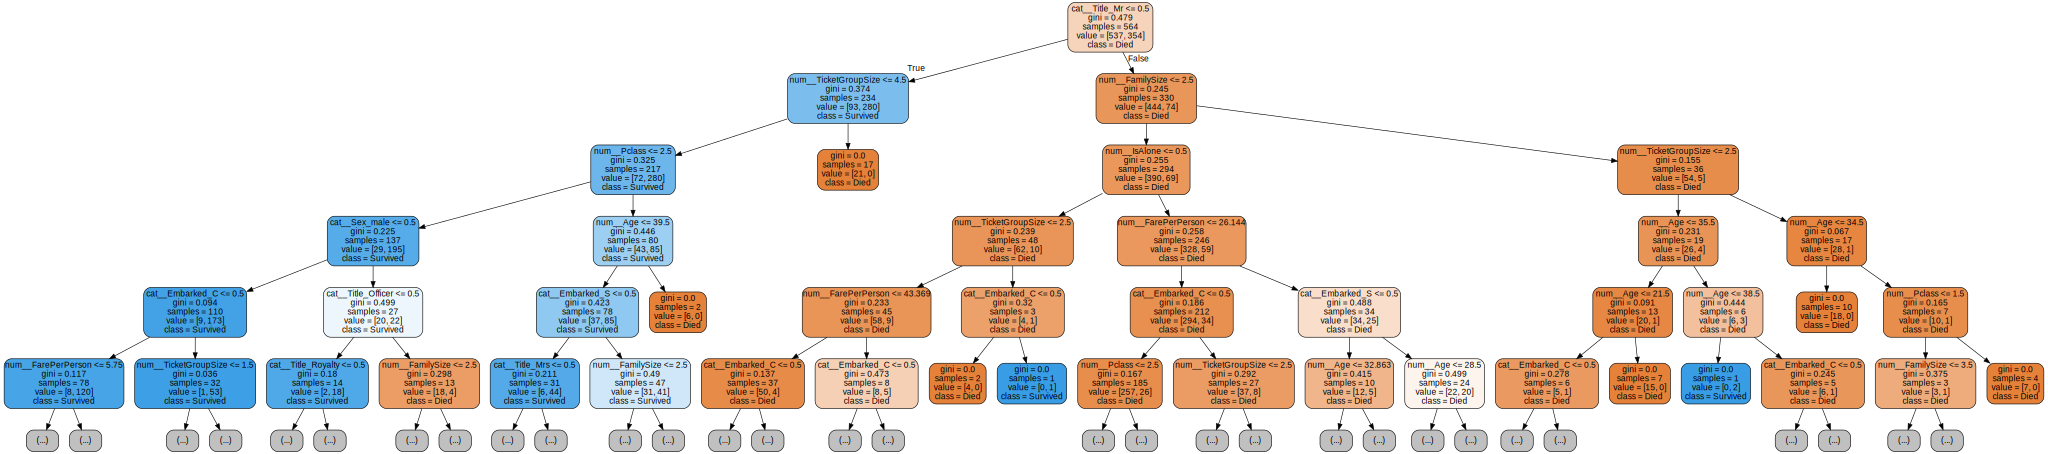

In [26]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from graphviz import Source

# 1) prendi il modello RF dalla pipeline (deve essere già fit)
rf = my_pipeline.named_steps["model"]

# 2) scegli un albero della foresta
estimator = rf.estimators_[0]   # prova anche 1,2,3...

# 3) nomi feature DOPO preprocessing
feature_names = my_pipeline.named_steps["preprocessor"].get_feature_names_out()

# 4) esporta
dot_data = export_graphviz(
    estimator,
    filled=True,
    rounded=True,
    feature_names=feature_names,
    max_depth=5,
    class_names=["Died", "Survived"],  # oppure ["0","1"]
    out_file=None
)

graph = graph_from_dot_data(dot_data)
graph.write_png("tree.png")


Source(dot_data)

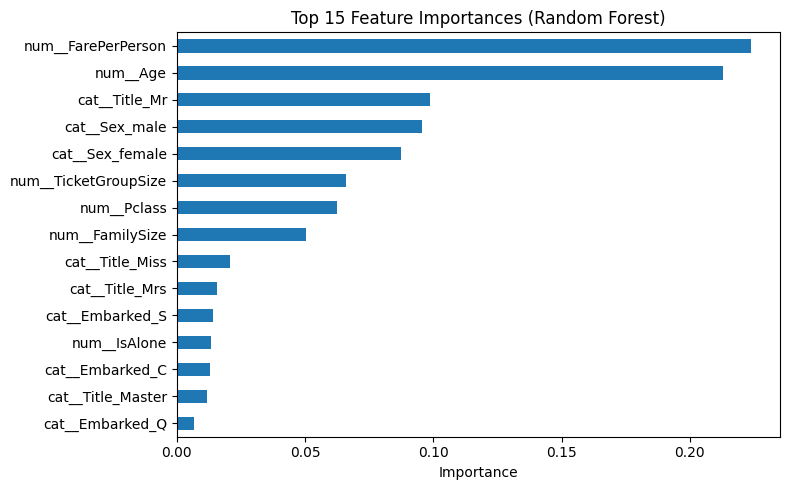

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

rf = my_pipeline.named_steps["model"]
feature_names = my_pipeline.named_steps["preprocessor"].get_feature_names_out()

importances = pd.Series(rf.feature_importances_, index=feature_names)
top = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
top.sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 5. Conclusions

In [28]:
output = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': preds
})
output.to_csv('submission.csv', index=False)
